In [1]:
import os
import pandas as pd
import dlib
import torch
from torch import nn
import torch.nn.functional as F
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob
import pathlib
from pathlib import Path
import torch.utils.data as data
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.integrate import simpson
from sklearn.metrics import auc
from tqdm.notebook import tqdm
import pickle

import torchvision
from torchvision.transforms import v2

In [2]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

In [3]:
# количество воркеров в лоадерах
NUM_WORKERS = 11

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # если есть gpu, то gpu
device

device(type='cuda')

In [436]:
%%bash

# if data directory doesn not exists, unzip landmarks_task.tgz to the current dir
# https://stackoverflow.com/questions/59838/how-do-i-check-if-a-directory-exists-or-not-in-a-bash-shell-script
if [ ! -d "./data" ]; then
  tar -xvzf './landmarks_task.tgz'
  mv ./landmarks_task ./data
fi

if [ ! -d "./model_weights" ]; then
    mkdir -p ./model_weights
    wget -O ./model_weights/mmod_human_face_detector.dat.bz2 http://dlib.net/files/mmod_human_face_detector.dat.bz2 
    bzip2 -dk ./model_weights/mmod_human_face_detector.dat.bz2

    wget -O ./model_weights/shape_predictor_68_face_landmarks.dat.bz2 http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    bzip2 -dk ./model_weights/shape_predictor_68_face_landmarks.dat.bz2
fi

In [6]:
face_detector_model_path = './model_weights/mmod_human_face_detector.dat'
face_detector = dlib.cnn_face_detection_model_v1(face_detector_model_path)

# image_path = "/home/ann/projects/vision_lab/data/300W/train/134212_1.jpg"
image_path = "./data/300W/train/2210851928_1.jpg"
# image_path = "./data/Menpo/train/aflw__face_39827.jpg"
img = dlib.load_rgb_image(image_path)

detections = face_detector(img, 1)
print(detections)

for face in detections:
    detection = face
    print(detection.confidence, detection.rect)
    left,top,right,bottom = detection.rect.left(),detection.rect.top(),detection.rect.right(),detection.rect.bottom()

mmod_rectangles[[(-30, 495) (2151, 2676)]]
1.0291084051132202 [(-30, 495) (2151, 2676)]


In [7]:
from PIL import Image

2298 3664


Создадим датасет из данных


In [6]:
# функция для чтения pts файла
def load_pts(path):
    """takes as input the path to a .pts and returns a list of 
	tuples of floats containing the points in in the form:
	[(x_0, y_0, z_0),
	 (x_1, y_1, z_1),
	 ...
	 (x_n, y_n, z_n)]"""
    with open(path) as f:
        rows = [rows.strip() for rows in f]
    
    """Use the curly braces to find the start and end of the point data""" 
    head = rows.index('{') + 1
    tail = rows.index('}')

    """Select the point data split into coordinates"""
    raw_points = rows[head:tail]
    coords_set = [point.split() for point in raw_points]

    """Convert entries from lists of strings to tuples of floats"""
    points = [[float(point) for point in coords] for coords in coords_set]
    return points

In [7]:
def get_rectangle(image_path, landmarks):
    face_detector_model_path = './model_weights/mmod_human_face_detector.dat'
    face_detector = dlib.cnn_face_detection_model_v1(face_detector_model_path)

    img = dlib.load_rgb_image(image_path)

    #надо найти тот прямоугольник, который соотествует real_landmarks, если на изображении несколько прямоугольников
    rect, point_in_rect, n_faces = find_true_rectangle(img, landmarks, face_detector)

    rect_x1 = rect[0]
    rect_y1 = rect[1]
    rect_x2 = rect[2]
    rect_y2 = rect[3]
    quantity_point = point_in_rect
    quantity_faces = n_faces

    return rect_x1, rect_y1, rect_x2,rect_y2,quantity_point, quantity_faces

In [8]:
def calculate_point_in_rect(box,landmarks):
    x1 = box[0]
    y1 = box[1]
    x2 = box[2]
    y2 = box[3]
    points = 0
    for point in landmarks:
        if (x1<point[0]<x2) and (y1<point[1]<y2):
            points+= 1 
    
    return(points)

In [9]:
def find_true_rectangle(img, landmarks, face_detector):
    detections = face_detector(img, 1)

    # создаем список боксов детекции для каждой картинки
    if len(detections) == 0:
        rect = [None, None, None, None]
        point_in_rect = None
    elif len(detections) >= 1:
        face_coords = [] # координаты боксов для детекций лица
        for face in detections: 
            rect = face.rect

            x1 = rect.left()
            y1 = rect.top()
            x2 = rect.right()
            y2 = rect.bottom()
                
            face_coords.append([x1,y1,x2,y2])

        if len(face_coords)==1:
            rect = face_coords[0]
            point_in_rect = calculate_point_in_rect(rect,landmarks)
        else:
            point_in_rect = []
            for box in face_coords:
                point_in_rect.append(calculate_point_in_rect(box,landmarks))

            rect = face_coords[np.argmax(point_in_rect)]

            point_in_rect = max(point_in_rect)
        
    return rect, point_in_rect, len(detections)

Получим train датафрейм Для 300W

In [10]:
image_dirs = (
        './data/300W/train/*.jpg', 
        './data/300W/train/*.png', 
        # './data/Menpo/train/*.jpg',
        # './data/Menpo/train/*.png',
)

new_data = []

for image_dir in image_dirs:
    for image_path in glob.glob(image_dir):
        image_dir_path = Path(image_path)
        landmark_path = image_dir_path.with_suffix('.pts')
        loaded_pts = load_pts(landmark_path)
        loaded_pts = np.array(loaded_pts, np.float64)
        rect_x1, rect_y1, rect_x2, rect_y2, quantity_point, quantity_faces = get_rectangle(str(image_dir_path), loaded_pts)
        n_landmarks = len(loaded_pts)

        new_data.append((image_path, loaded_pts, rect_x1, rect_y1, rect_x2,rect_y2,quantity_point, quantity_faces, n_landmarks))

data_df = pd.DataFrame(new_data, columns = ['image_dir','real_landmarks','rect_x1', 'rect_y1', 'rect_x2','rect_y2','quantity_point', 'quantity_faces', 'n_landmarks'])

data_df

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
0,./data/300W/train/2528689679_1.jpg,"[[172.229303, 316.760604], [159.431724, 384.84...",167,83,776,692,62,1,68
1,./data/300W/train/82161078_1.jpg,"[[240.411956, 229.168365], [244.346417, 279.38...",280,173,574,467,59,1,68
2,./data/300W/train/2848544488_1.jpg,"[[320.702433, 530.589342], [314.168263, 580.54...",314,352,736,774,56,1,68
3,./data/300W/train/2398716782_1.jpg,"[[666.546674, 792.712815], [654.549491, 841.21...",506,561,1115,1169,64,1,68
4,./data/300W/train/2210851928_1.jpg,"[[378.935651, 1527.385891], [352.192956, 1776....",-30,495,2151,2676,55,1,68
...,...,...,...,...,...,...,...,...,...
3287,./data/300W/train/image_0383.png,"[[258.498963, 244.7461], [252.443662, 287.5299...",218,184,462,429,58,1,68
3288,./data/300W/train/image_0422.png,"[[103.617833, 210.394115], [106.891859, 240.34...",72,94,317,339,62,1,68
3289,./data/300W/train/image_0330.png,"[[729.097274, 1727.684451], [731.100208, 1783....",608,1520,1115,2027,58,2,68
3290,./data/300W/train/image_0453.png,"[[154.674187, 178.404656], [154.437681, 191.97...",153,143,271,261,64,2,68


In [11]:
#Проверим на те фотки где не 68 точек
data_df[data_df['n_landmarks'] != 68]

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks


Удалим те строки из датафрейма, где n_landmarks < 68

In [12]:
data_df = data_df[data_df['n_landmarks'] == 68]
data_df

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
0,./data/300W/train/2528689679_1.jpg,"[[172.229303, 316.760604], [159.431724, 384.84...",167,83,776,692,62,1,68
1,./data/300W/train/82161078_1.jpg,"[[240.411956, 229.168365], [244.346417, 279.38...",280,173,574,467,59,1,68
2,./data/300W/train/2848544488_1.jpg,"[[320.702433, 530.589342], [314.168263, 580.54...",314,352,736,774,56,1,68
3,./data/300W/train/2398716782_1.jpg,"[[666.546674, 792.712815], [654.549491, 841.21...",506,561,1115,1169,64,1,68
4,./data/300W/train/2210851928_1.jpg,"[[378.935651, 1527.385891], [352.192956, 1776....",-30,495,2151,2676,55,1,68
...,...,...,...,...,...,...,...,...,...
3287,./data/300W/train/image_0383.png,"[[258.498963, 244.7461], [252.443662, 287.5299...",218,184,462,429,58,1,68
3288,./data/300W/train/image_0422.png,"[[103.617833, 210.394115], [106.891859, 240.34...",72,94,317,339,62,1,68
3289,./data/300W/train/image_0330.png,"[[729.097274, 1727.684451], [731.100208, 1783....",608,1520,1115,2027,58,2,68
3290,./data/300W/train/image_0453.png,"[[154.674187, 178.404656], [154.437681, 191.97...",153,143,271,261,64,2,68


In [31]:
#Проверим на Nan
data_df[data_df.isna().any(axis=1)]

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks


In [19]:
data_df = data_df[~data_df.isna().any(axis=1)]
data_df.reset_index(drop = True, inplace = True)

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
0,./data/300W/train/2528689679_1.jpg,"[[172.22931, 316.7606], [159.43172, 384.84048]...",167,83,776,692,62,1,68
1,./data/300W/train/82161078_1.jpg,"[[240.41196, 229.16837], [244.34642, 279.38422...",280,173,574,467,59,1,68
2,./data/300W/train/2848544488_1.jpg,"[[320.70242, 530.58936], [314.16827, 580.54486...",314,352,736,774,56,1,68
3,./data/300W/train/2398716782_1.jpg,"[[666.5467, 792.7128], [654.5495, 841.2146], [...",506,561,1115,1169,64,1,68
4,./data/300W/train/2210851928_1.jpg,"[[378.93564, 1527.3859], [352.19296, 1776.2589...",-30,495,2151,2676,55,1,68
...,...,...,...,...,...,...,...,...,...
3287,./data/300W/train/image_0383.png,"[[258.49896, 244.7461], [252.44366, 287.52994]...",218,184,462,429,58,1,68
3288,./data/300W/train/image_0422.png,"[[103.617836, 210.39412], [106.89186, 240.3437...",72,94,317,339,62,1,68
3289,./data/300W/train/image_0330.png,"[[729.0973, 1727.6844], [731.1002, 1783.3721],...",608,1520,1115,2027,58,2,68
3290,./data/300W/train/image_0453.png,"[[154.6742, 178.40466], [154.43768, 191.97498]...",153,143,271,261,64,2,68


Получим test датафрейм Для 300W

In [247]:
image_dirs = (
        './data/300W/test/*.jpg', 
        './data/300W/test/*.png', 
)

new_data = []

for image_dir in image_dirs:
    for image_path in glob.glob(image_dir):
        image_dir_path = Path(image_path)
        landmark_path = image_dir_path.with_suffix('.pts')
        loaded_pts = load_pts(landmark_path)
        loaded_pts = np.array(loaded_pts, np.float64)
        rect_x1, rect_y1, rect_x2, rect_y2, quantity_point, quantity_faces = get_rectangle(str(image_dir_path), loaded_pts)
        n_landmarks = len(loaded_pts)

        new_data.append((image_path, loaded_pts, rect_x1, rect_y1, rect_x2,rect_y2,quantity_point, quantity_faces, n_landmarks))

data_df = pd.DataFrame(new_data, columns = ['image_dir','real_landmarks','rect_x1', 'rect_y1', 'rect_x2','rect_y2','quantity_point', 'quantity_faces', 'n_landmarks'])

data_df

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
0,./data/300W/test/2353849_1.jpg,"[[983.038021, 505.696833], [979.348039, 525.77...",961,437,1131,607,62,2,68
1,./data/300W/test/2710033361_1.jpg,"[[541.356642, 888.587796], [560.29636, 996.991...",525,553,1255,1283,51,1,68
2,./data/300W/test/111076519_1.jpg,"[[1126.573515, 766.06897], [1123.954471, 784.9...",1121,722,1263,864,61,2,68
3,./data/300W/test/2529559836_2.jpg,"[[261.162329, 506.998517], [260.971802, 555.04...",216,355,569,707,52,1,68
4,./data/300W/test/107635070_1.jpg,"[[19.205631, 243.648393], [22.922807, 290.7214...",-13,52,410,475,62,1,68
...,...,...,...,...,...,...,...,...,...
376,./data/300W/test/image_0252.png,"[[30.352469, 197.20313], [28.183239, 218.59918...",2,140,172,310,61,2,68
377,./data/300W/test/image_0291.png,"[[207.697473, 136.84641], [208.018943, 148.994...",216,104,314,203,52,1,68
378,./data/300W/test/image_0684.png,"[[153.421811, 123.666432], [151.348682, 149.46...",130,35,333,238,52,1,68
379,./data/300W/test/image_0040.png,"[[97.257614, 184.556472], [98.755593, 200.2612...",84,101,226,242,37,1,68


In [248]:
data_df[data_df['n_landmarks'] != 68]

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks


In [249]:
data_df = data_df[data_df['n_landmarks'] == 68]
#Проверим на Nan
data_df[data_df.isna().any(axis=1)]

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks


In [250]:
data_df = data_df[~data_df.isna().any(axis=1)]
data_df.reset_index(drop = True, inplace = True)

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
0,./data/300W/test/2353849_1.jpg,"[[983.038021, 505.696833], [979.348039, 525.77...",961,437,1131,607,62,2,68
1,./data/300W/test/2710033361_1.jpg,"[[541.356642, 888.587796], [560.29636, 996.991...",525,553,1255,1283,51,1,68
2,./data/300W/test/111076519_1.jpg,"[[1126.573515, 766.06897], [1123.954471, 784.9...",1121,722,1263,864,61,2,68
3,./data/300W/test/2529559836_2.jpg,"[[261.162329, 506.998517], [260.971802, 555.04...",216,355,569,707,52,1,68
4,./data/300W/test/107635070_1.jpg,"[[19.205631, 243.648393], [22.922807, 290.7214...",-13,52,410,475,62,1,68
...,...,...,...,...,...,...,...,...,...
376,./data/300W/test/image_0252.png,"[[30.352469, 197.20313], [28.183239, 218.59918...",2,140,172,310,61,2,68
377,./data/300W/test/image_0291.png,"[[207.697473, 136.84641], [208.018943, 148.994...",216,104,314,203,52,1,68
378,./data/300W/test/image_0684.png,"[[153.421811, 123.666432], [151.348682, 149.46...",130,35,333,238,52,1,68
379,./data/300W/test/image_0040.png,"[[97.257614, 184.556472], [98.755593, 200.2612...",84,101,226,242,37,1,68


In [251]:
data_df.to_pickle('df_300W_test.pickle',
              compression=None)

Получим датафрейм Для Menpo

In [403]:
image_dirs = (
        './data/Menpo/train/*.jpg', 
        './data/Menpo/train/*.png', 
)

new_data = []

for image_dir in image_dirs:
    for image_path in glob.glob(image_dir):
        image_dir_path = Path(image_path)
        landmark_path = image_dir_path.with_suffix('.pts')
        loaded_pts = load_pts(landmark_path)
        loaded_pts = np.array(loaded_pts, np.float64)
        rect_x1, rect_y1, rect_x2, rect_y2, quantity_point, quantity_faces = get_rectangle(str(image_dir_path), loaded_pts)
        n_landmarks = len(loaded_pts)

        new_data.append((image_path, loaded_pts, rect_x1, rect_y1, rect_x2,rect_y2,quantity_point, quantity_faces, n_landmarks))

data_df = pd.DataFrame(new_data, columns = ['image_dir','real_landmarks','rect_x1', 'rect_y1', 'rect_x2','rect_y2','quantity_point', 'quantity_faces', 'n_landmarks'])

data_df

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
0,./data/Menpo/train/aflw__face_65152.jpg,"[[43.627, 49.963], [42.909, 57.026], [41.952, ...",36.0,32.0,93.0,89.0,55.0,1,68
1,./data/Menpo/train/aflw__face_39857.jpg,"[[401.629, 154.155], [392.437, 188.453], [378....",131.0,26.0,376.0,271.0,31.0,1,39
2,./data/Menpo/train/aflw__face_41589.jpg,"[[535.178, 572.639], [540.846, 707.536], [555....",619.0,442.0,1496.0,1319.0,55.0,1,68
3,./data/Menpo/train/aflw__face_48252.jpg,"[[84.097, 133.274], [86.63, 147.041], [92.907,...",61.0,79.0,179.0,197.0,59.0,1,68
4,./data/Menpo/train/aflw__face_43920.jpg,"[[29.587, 214.849], [43.879, 257.057], [58.617...",69.0,110.0,314.0,355.0,29.0,1,39
...,...,...,...,...,...,...,...,...,...
8076,./data/Menpo/train/aflw__face_65146.jpg,"[[72.02, 95.025], [70.759, 100.831], [71.614, ...",61.0,53.0,143.0,135.0,64.0,1,68
8077,./data/Menpo/train/aflw__face_45080.jpg,"[[624.473, 606.754], [617.736, 699.128], [626....",543.0,424.0,1274.0,1154.0,60.0,1,68
8078,./data/Menpo/train/aflw__face_43834.jpg,"[[113.137, 257.197], [115.757, 333.55], [125.8...",81.0,95.0,589.0,602.0,62.0,1,68
8079,./data/Menpo/train/aflw__face_41605.jpg,"[[86.68, 112.875], [88.044, 132.127], [90.708,...",82.0,70.0,224.0,212.0,65.0,1,68


In [404]:
data_df[data_df['n_landmarks'] != 68]

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
1,./data/Menpo/train/aflw__face_39857.jpg,"[[401.629, 154.155], [392.437, 188.453], [378....",131.0,26.0,376.0,271.0,31.0,1,39
4,./data/Menpo/train/aflw__face_43920.jpg,"[[29.587, 214.849], [43.879, 257.057], [58.617...",69.0,110.0,314.0,355.0,29.0,1,39
5,./data/Menpo/train/aflw__face_43727.jpg,"[[567.879, 648.63], [569.355, 746.865], [576.2...",571.0,488.0,1301.0,1219.0,33.0,1,39
9,./data/Menpo/train/aflw__face_42352.jpg,"[[71.875, 105.135], [75.03, 116.964], [78.606,...",69.0,59.0,167.0,158.0,32.0,1,39
13,./data/Menpo/train/aflw__face_42856.jpg,"[[60.889, 57.911], [60.021, 71.147], [59.153, ...",47.0,42.0,145.0,140.0,28.0,1,39
...,...,...,...,...,...,...,...,...,...
8048,./data/Menpo/train/aflw__face_45854.jpg,"[[531.744, 682.833], [565.136, 765.589], [601....",599.0,422.0,1207.0,1031.0,31.0,1,39
8062,./data/Menpo/train/aflw__face_47229.jpg,"[[188.434, 130.103], [188.079, 147.875], [187....",44.0,73.0,162.0,191.0,25.0,1,39
8064,./data/Menpo/train/aflw__face_40829.jpg,"[[196.874, 253.453], [202.996, 298.644], [210....",158.0,101.0,511.0,453.0,33.0,1,39
8066,./data/Menpo/train/aflw__face_61130.jpg,"[[49.353, 62.223], [49.71, 70.801], [50.639, 8...",51.0,40.0,119.0,108.0,32.0,1,39


In [405]:
data_df = data_df[data_df['n_landmarks'] == 68]
#Проверим на Nan
data_df[data_df.isna().any(axis=1)]

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
86,./data/Menpo/train/aflw__face_43325.jpg,"[[23.531, 31.705], [23.932, 36.524], [24.579, ...",NaN,NaN,NaN,NaN,NaN,0,68
192,./data/Menpo/train/aflw__face_42536.jpg,"[[62.612, 113.129], [63.491, 126.764], [66.306...",NaN,NaN,NaN,NaN,NaN,0,68
402,./data/Menpo/train/aflw__face_61835.jpg,"[[21.958, 26.853], [21.903, 30.729], [22.34, 3...",NaN,NaN,NaN,NaN,NaN,0,68
542,./data/Menpo/train/aflw__face_61201.jpg,"[[21.343, 25.92], [21.519, 29.556], [21.988, 3...",NaN,NaN,NaN,NaN,NaN,0,68
1114,./data/Menpo/train/aflw__face_40429.jpg,"[[358.126, 591.642], [341.609, 702.654], [341....",NaN,NaN,NaN,NaN,NaN,0,68
1863,./data/Menpo/train/aflw__face_61354.jpg,"[[19.804, 24.085], [19.807, 27.368], [20.174, ...",NaN,NaN,NaN,NaN,NaN,0,68
2008,./data/Menpo/train/aflw__face_62201.jpg,"[[18.771, 26.201], [19.413, 29.711], [20.227, ...",NaN,NaN,NaN,NaN,NaN,0,68
2110,./data/Menpo/train/aflw__face_41678.jpg,"[[184.463, 348.012], [234.43, 342.658], [282.6...",NaN,NaN,NaN,NaN,NaN,0,68
2221,./data/Menpo/train/aflw__face_43034.jpg,"[[165.026, 113.594], [167.751, 137.3], [169.38...",NaN,NaN,NaN,NaN,NaN,0,68
2293,./data/Menpo/train/aflw__face_45108.jpg,"[[181.421, 368.6], [206.975, 386.946], [235.80...",NaN,NaN,NaN,NaN,NaN,0,68


In [406]:
data_df = data_df[~data_df.isna().any(axis=1)]
data_df.reset_index(drop = True, inplace = True)

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
0,./data/Menpo/train/aflw__face_65152.jpg,"[[43.627, 49.963], [42.909, 57.026], [41.952, ...",36.0,32.0,93.0,89.0,55.0,1,68
2,./data/Menpo/train/aflw__face_41589.jpg,"[[535.178, 572.639], [540.846, 707.536], [555....",619.0,442.0,1496.0,1319.0,55.0,1,68
3,./data/Menpo/train/aflw__face_48252.jpg,"[[84.097, 133.274], [86.63, 147.041], [92.907,...",61.0,79.0,179.0,197.0,59.0,1,68
6,./data/Menpo/train/aflw__face_42728.jpg,"[[78.98, 92.221], [78.11, 109.619], [79.049, 1...",62.0,65.0,204.0,206.0,59.0,1,68
7,./data/Menpo/train/aflw__face_45218.jpg,"[[116.384, 154.215], [113.931, 173.853], [115....",101.0,97.0,271.0,267.0,61.0,1,68
...,...,...,...,...,...,...,...,...,...
8076,./data/Menpo/train/aflw__face_65146.jpg,"[[72.02, 95.025], [70.759, 100.831], [71.614, ...",61.0,53.0,143.0,135.0,64.0,1,68
8077,./data/Menpo/train/aflw__face_45080.jpg,"[[624.473, 606.754], [617.736, 699.128], [626....",543.0,424.0,1274.0,1154.0,60.0,1,68
8078,./data/Menpo/train/aflw__face_43834.jpg,"[[113.137, 257.197], [115.757, 333.55], [125.8...",81.0,95.0,589.0,602.0,62.0,1,68
8079,./data/Menpo/train/aflw__face_41605.jpg,"[[86.68, 112.875], [88.044, 132.127], [90.708,...",82.0,70.0,224.0,212.0,65.0,1,68


In [408]:
data_df.to_pickle('df_Menpo.pickle',
              compression=None)  

Создадим датасет Test для Menpo

In [409]:
image_dirs = (
        './data/Menpo/test/*.jpg', 
        './data/Menpo/test/*.png', 
)

new_data = []

for image_dir in image_dirs:
    for image_path in glob.glob(image_dir):
        image_dir_path = Path(image_path)
        landmark_path = image_dir_path.with_suffix('.pts')
        loaded_pts = load_pts(landmark_path)
        loaded_pts = np.array(loaded_pts, np.float64)
        rect_x1, rect_y1, rect_x2, rect_y2, quantity_point, quantity_faces = get_rectangle(str(image_dir_path), loaded_pts)
        n_landmarks = len(loaded_pts)

        new_data.append((image_path, loaded_pts, rect_x1, rect_y1, rect_x2,rect_y2,quantity_point, quantity_faces, n_landmarks))

data_df = pd.DataFrame(new_data, columns = ['image_dir','real_landmarks','rect_x1', 'rect_y1', 'rect_x2','rect_y2','quantity_point', 'quantity_faces', 'n_landmarks'])

data_df

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
0,./data/Menpo/test/aflw__face_40656.jpg,"[[373.862, 405.73], [361.104, 489.078], [356.4...",357.0,332.0,865.0,839.0,58.0,1,68
1,./data/Menpo/test/aflw__face_45431.jpg,"[[97.429, 149.92], [103.294, 170.166], [110.29...",111.0,99.0,252.0,240.0,60.0,1,68
2,./data/Menpo/test/aflw__face_62296.jpg,"[[43.365, 54.52], [43.65, 60.272], [44.221, 66...",36.0,27.0,93.0,83.0,57.0,1,68
3,./data/Menpo/test/aflw__face_46522.jpg,"[[60.406, 79.666], [61.207, 88.885], [62.944, ...",53.0,45.0,135.0,127.0,61.0,1,68
4,./data/Menpo/test/aflw__face_64997.jpg,"[[121.388, 339.202], [131.677, 371.279], [145....",91.0,192.0,384.0,485.0,57.0,1,68
...,...,...,...,...,...,...,...,...,...
893,./data/Menpo/test/aflw__face_62383.jpg,"[[43.465, 57.268], [42.735, 65.527], [43.206, ...",30.0,36.0,98.0,104.0,56.0,1,68
894,./data/Menpo/test/aflw__face_63468.jpg,"[[94.606, 123.316], [94.44, 136.701], [96.093,...",66.0,61.0,208.0,203.0,61.0,1,68
895,./data/Menpo/test/aflw__face_64435.jpg,"[[92.942, 120.016], [91.463, 135.927], [93.51,...",61.0,45.0,202.0,187.0,52.0,1,68
896,./data/Menpo/test/fddb__image2646_1.jpg,"[[105.538, 139.849], [106.785, 158.314], [106....",86.0,92.0,227.0,233.0,57.0,2,68


In [416]:
data_df[data_df['n_landmarks'] != 68]

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
5,./data/Menpo/test/aflw__face_63919.jpg,"[[113.849, 142.981], [109.825, 162.098], [106....",88.0,65.0,258.0,235.0,32.0,2,39
6,./data/Menpo/test/aflw__face_47561.jpg,"[[1476.798, 429.799], [1471.757, 556.557], [14...",371.0,318.0,1422.0,1370.0,32.0,1,39
8,./data/Menpo/test/aflw__face_45537.jpg,"[[28.991, 31.091], [28.821, 36.998], [28.906, ...",29.0,17.0,68.0,57.0,30.0,1,39
9,./data/Menpo/test/aflw__face_43768.jpg,"[[35.01, 40.064], [35.747, 46.696], [36.713, 5...",25.0,24.0,82.0,81.0,35.0,1,39
11,./data/Menpo/test/aflw__face_42833.jpg,"[[50.361, 61.932], [51.562, 69.399], [52.678, ...",37.0,36.0,105.0,104.0,34.0,1,39
...,...,...,...,...,...,...,...,...,...
883,./data/Menpo/test/aflw__face_44156.jpg,"[[732.953, 875.77], [771.119, 1021.714], [813....",650.0,584.0,1702.0,1636.0,33.0,1,39
887,./data/Menpo/test/aflw__face_65020.jpg,"[[807.158, 620.276], [812.879, 754.688], [827....",637.0,305.0,1689.0,1356.0,36.0,1,39
888,./data/Menpo/test/aflw__face_45019.jpg,"[[89.735, 110.913], [92.141, 127.96], [94.748,...",57.0,68.0,199.0,210.0,37.0,1,39
889,./data/Menpo/test/aflw__face_43494.jpg,"[[58.365, 82.986], [64.175, 95.795], [69.898, ...",32.0,33.0,150.0,151.0,35.0,1,39


In [417]:
data_df = data_df[data_df['n_landmarks'] == 68]
#Проверим на Nan
data_df[data_df.isna().any(axis=1)]

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
30,./data/Menpo/test/aflw__face_61199.jpg,"[[15.863, 24.689], [16.279, 27.982], [16.937, ...",NaN,NaN,NaN,NaN,NaN,0,68
445,./data/Menpo/test/aflw__face_61427.jpg,"[[21.774, 25.295], [21.533, 29.217], [21.74, 3...",NaN,NaN,NaN,NaN,NaN,0,68
489,./data/Menpo/test/aflw__face_42279.jpg,"[[45.398, 49.934], [45.814, 55.942], [47.063, ...",NaN,NaN,NaN,NaN,NaN,0,68
619,./data/Menpo/test/aflw__face_44760.jpg,"[[159.382, 151.929], [146.176, 172.758], [136....",NaN,NaN,NaN,NaN,NaN,0,68


In [418]:
data_df = data_df[~data_df.isna().any(axis=1)]
data_df.reset_index(drop = True, inplace = True)

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
0,./data/Menpo/test/aflw__face_40656.jpg,"[[373.862, 405.73], [361.104, 489.078], [356.4...",357.0,332.0,865.0,839.0,58.0,1,68
1,./data/Menpo/test/aflw__face_45431.jpg,"[[97.429, 149.92], [103.294, 170.166], [110.29...",111.0,99.0,252.0,240.0,60.0,1,68
2,./data/Menpo/test/aflw__face_62296.jpg,"[[43.365, 54.52], [43.65, 60.272], [44.221, 66...",36.0,27.0,93.0,83.0,57.0,1,68
3,./data/Menpo/test/aflw__face_46522.jpg,"[[60.406, 79.666], [61.207, 88.885], [62.944, ...",53.0,45.0,135.0,127.0,61.0,1,68
4,./data/Menpo/test/aflw__face_64997.jpg,"[[121.388, 339.202], [131.677, 371.279], [145....",91.0,192.0,384.0,485.0,57.0,1,68
...,...,...,...,...,...,...,...,...,...
893,./data/Menpo/test/aflw__face_62383.jpg,"[[43.465, 57.268], [42.735, 65.527], [43.206, ...",30.0,36.0,98.0,104.0,56.0,1,68
894,./data/Menpo/test/aflw__face_63468.jpg,"[[94.606, 123.316], [94.44, 136.701], [96.093,...",66.0,61.0,208.0,203.0,61.0,1,68
895,./data/Menpo/test/aflw__face_64435.jpg,"[[92.942, 120.016], [91.463, 135.927], [93.51,...",61.0,45.0,202.0,187.0,52.0,1,68
896,./data/Menpo/test/fddb__image2646_1.jpg,"[[105.538, 139.849], [106.785, 158.314], [106....",86.0,92.0,227.0,233.0,57.0,2,68


In [422]:
data_df.to_pickle('df_Menpo_test.pickle',
              compression=None)  
# pd.read_parquet('df.parquet.gzip')

Соберем  Dataset

In [5]:
class ImagesDataset(data.Dataset):
  def __init__(self, df, image_size = 48,  transform = None, target_transform = None):
    self.image_size = image_size
    self.transform = transform
    self.target_transform = target_transform

    self.df = df 

  def __getitem__(self, idx):
    image_path = self.df["image_dir"][idx]        

    image = Image.open(image_path).convert('RGB')

    real_landmarks = self.df["real_landmarks"][idx]


    x1 = int(self.df["rect_x1"][idx])
    y1 = int(self.df["rect_y1"][idx])
    x2 = int(self.df["rect_x2"][idx])
    y2 = int(self.df["rect_y2"][idx])

    rect = np.array([x1,y1,x2,y2])

    landmarks_in_bbox = self.df["quantity_point"][idx]

    old = landmarks_in_bbox

    # if landmarks_in_bbox != 68:
    #   rect = self.scale_rect(rect, image.size, percentage=0.3)
    #   landmarks_in_bbox = self.calculate_point_in_rect(rect,real_landmarks)
    resized_landmarks = None

    if self.transform:
      #crop image by bbox
      x1 = rect[0] 
      y1 = rect[1] 
      x2 = rect[2] 
      y2 = rect[3] 
      # # check что rect не за пределами изображения
      if x1 < 0:
          x1 = 0
      if x2 > image.size[0]:
          x2 = image.size[0]
      if y1 < 0:
          y1 = 0
      if y2 > image.size[1]:
          y2 = image.size[1]

      image = image.crop((x1,y1,x2,y2))
      image_crop = image

      cropped_landmarks = np.zeros((68,2))
      cropped_landmarks[:,0] = real_landmarks[:,0] - np.full(len(cropped_landmarks), x1)
      cropped_landmarks[:,1] = real_landmarks[:,1] - np.full(len(cropped_landmarks), y1)

      #resize image 
      # image = image.resize(self.image_size, self.image_size)
      image = self.transform(image)  #image.shape - CxHxW

      #Scale точек после resize
      scale_x = self.image_size / image_crop.size[0]  #image.size - WxH
      scale_y = self.image_size / image_crop.size[1]

      resized_landmarks = np.zeros((68,2))

      resized_landmarks[:,0] = cropped_landmarks[:,0]*scale_x
      resized_landmarks[:,1] = cropped_landmarks[:,1]*scale_y

      resized_landmarks = resized_landmarks
        
    if self.target_transform:
        label = self.target_transform(label)

    return image, real_landmarks, resized_landmarks, rect
  
  def scale_rect(self, rect, image_size, percentage=0.20):
        x1 = rect[0]
        y1 = rect[1]
        x2 = rect[2]
        y2 = rect[3]

        h = y2 - y1
        w = x2 - x1

        new_x1 = int(x1 - percentage*w)
        new_x2 = int(x2 + percentage*w)
        new_y1 = int(y1 - percentage*h)
        new_y2 = int(y2 + percentage*h)

        if new_x1 < 0:
            new_x1 = 0
        if new_x2 > image_size[0]:
            new_x2 = image_size[0]
        if new_y1 < 0:
            new_y1 = 0
        if new_y2 > image_size[1]:
            new_y2 = image_size[1]

        new_rect = np.array([new_x1, new_y1, new_x2, new_y2])

        return new_rect

  def calculate_point_in_rect(self, box, landmarks):
    x1 = box[0]
    y1 = box[1]
    x2 = box[2]
    y2 = box[3]
    points = 0
    for point in landmarks:
      if (x1<point[0]<x2) and (y1<point[1]<y2):
          points+= 1 
      
    return(points)
  
  def __len__(self):
    return len(self.df)

In [6]:
IMAGE_SIZE = 48
data_transforms = {
    'train': v2.Compose([
        v2.ToImage(), # Convert to tensor, only needed if you had a PIL image
        v2.ToDtype(torch.uint8, scale=True),# optional, most input are already uint8 at this point
        v2.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
     ]),
    'val': v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.uint8, scale=True),
        v2.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
def get_data(data = '300W', USE_VAL_DATASET= True ):
  if data == '300W' and USE_VAL_DATASET:
    train, val = train_test_split(pd.read_pickle('/home/ann/projects/vision_lab/df_300W.pickle'), test_size=0.2, random_state=24)
    test = pd.read_pickle('/home/ann/projects/vision_lab/df_300W_test.pickle')
  elif data == 'Menpo' and USE_VAL_DATASET: 
    train, val = train_test_split(pd.read_pickle('/home/ann/projects/vision_lab/df_Menpo.pickle'), test_size=0.2, random_state=24)
    test = pd.read_pickle('/home/ann/projects/vision_lab/df_Menpo_test.pickle')
  elif data == '300W'and USE_VAL_DATASET==False: 
    train = pd.read_pickle('/home/ann/projects/vision_lab/df_300W.pickle')
    val = None
    test = pd.read_pickle('/home/ann/projects/vision_lab/df_300W_test.pickle')
  elif data == 'Menpo'and USE_VAL_DATASET==False:
    train = pd.read_pickle('/home/ann/projects/vision_lab/df_Menpo.pickle')
    val = None
    test = pd.read_pickle('/home/ann/projects/vision_lab/df_Menpo_test.pickle')
  return train, val, test

In [35]:
train_df, val_df, test_df  = get_data(data = '300W', USE_VAL_DATASET= True)

train_df.reset_index(drop = True, inplace = True)
val_df.reset_index(drop = True, inplace = True)
test_df.reset_index(drop = True, inplace = True)

train_dataset = ImagesDataset(
    df = train_df,
    transform = data_transforms['train']
)

val_dataset = None
if val_df is not None:
    val_dataset = ImagesDataset(
        df = val_df,
        transform = data_transforms['val']
    )

test_dataset = ImagesDataset(
    df=test_df,
    transform=data_transforms['val']
)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True) if val_dataset else None
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

In [32]:
train_df

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
0,./data/Menpo/train/aflw__face_61913.jpg,"[[90.854, 106.116], [88.45, 116.374], [86.686,...",64.0,55.0,182.0,173.0,57.0,1,68
1,./data/Menpo/train/aflw__face_61572.jpg,"[[48.474, 60.327], [49.233, 69.635], [50.694, ...",51.0,35.0,119.0,103.0,62.0,1,68
2,./data/Menpo/train/aflw__face_61934.jpg,"[[78.57, 92.482], [81.465, 106.803], [85.067, ...",74.0,62.0,172.0,160.0,53.0,1,68
3,./data/Menpo/train/aflw__face_43894.jpg,"[[746.689, 778.174], [756.74, 924.138], [776.6...",797.0,431.0,1673.0,1307.0,59.0,1,68
4,./data/Menpo/train/aflw__face_41484.jpg,"[[60.335, 78.512], [59.729, 89.272], [60.486, ...",53.0,45.0,135.0,127.0,58.0,2,68
...,...,...,...,...,...,...,...,...,...
4767,./data/Menpo/train/aflw__face_42441.jpg,"[[42.744, 72.443], [45.399, 79.577], [48.848, ...",30.0,35.0,98.0,103.0,61.0,1,68
4768,./data/Menpo/train/aflw__face_65244.jpg,"[[50.708, 71.05], [52.52, 80.485], [54.927, 92...",36.0,33.0,118.0,115.0,56.0,1,68
4769,./data/Menpo/train/aflw__face_63876.jpg,"[[103.638, 141.975], [108.177, 161.401], [113....",95.0,76.0,236.0,217.0,57.0,1,68
4770,./data/Menpo/train/aflw__face_63188.jpg,"[[152.548, 175.283], [152.162, 208.449], [152....",140.0,104.0,344.0,308.0,58.0,1,68


In [34]:
test_df

,image_dir,real_landmarks,rect_x1,rect_y1,rect_x2,rect_y2,quantity_point,quantity_faces,n_landmarks
0,./data/Menpo/test/aflw__face_40656.jpg,"[[373.862, 405.73], [361.104, 489.078], [356.4...",357.0,332.0,865.0,839.0,58.0,1,68
1,./data/Menpo/test/aflw__face_45431.jpg,"[[97.429, 149.92], [103.294, 170.166], [110.29...",111.0,99.0,252.0,240.0,60.0,1,68
2,./data/Menpo/test/aflw__face_62296.jpg,"[[43.365, 54.52], [43.65, 60.272], [44.221, 66...",36.0,27.0,93.0,83.0,57.0,1,68
3,./data/Menpo/test/aflw__face_46522.jpg,"[[60.406, 79.666], [61.207, 88.885], [62.944, ...",53.0,45.0,135.0,127.0,61.0,1,68
4,./data/Menpo/test/aflw__face_64997.jpg,"[[121.388, 339.202], [131.677, 371.279], [145....",91.0,192.0,384.0,485.0,57.0,1,68
...,...,...,...,...,...,...,...,...,...
652,./data/Menpo/test/aflw__face_62383.jpg,"[[43.465, 57.268], [42.735, 65.527], [43.206, ...",30.0,36.0,98.0,104.0,56.0,1,68
653,./data/Menpo/test/aflw__face_63468.jpg,"[[94.606, 123.316], [94.44, 136.701], [96.093,...",66.0,61.0,208.0,203.0,61.0,1,68
654,./data/Menpo/test/aflw__face_64435.jpg,"[[92.942, 120.016], [91.463, 135.927], [93.51,...",61.0,45.0,202.0,187.0,52.0,1,68
655,./data/Menpo/test/fddb__image2646_1.jpg,"[[105.538, 139.849], [106.785, 158.314], [106....",86.0,92.0,227.0,233.0,57.0,2,68


In [33]:
images, real_landmarks, resized_landmarks, rect  = next(iter(train_loader))
images.shape

torch.Size([64, 3, 48, 48])

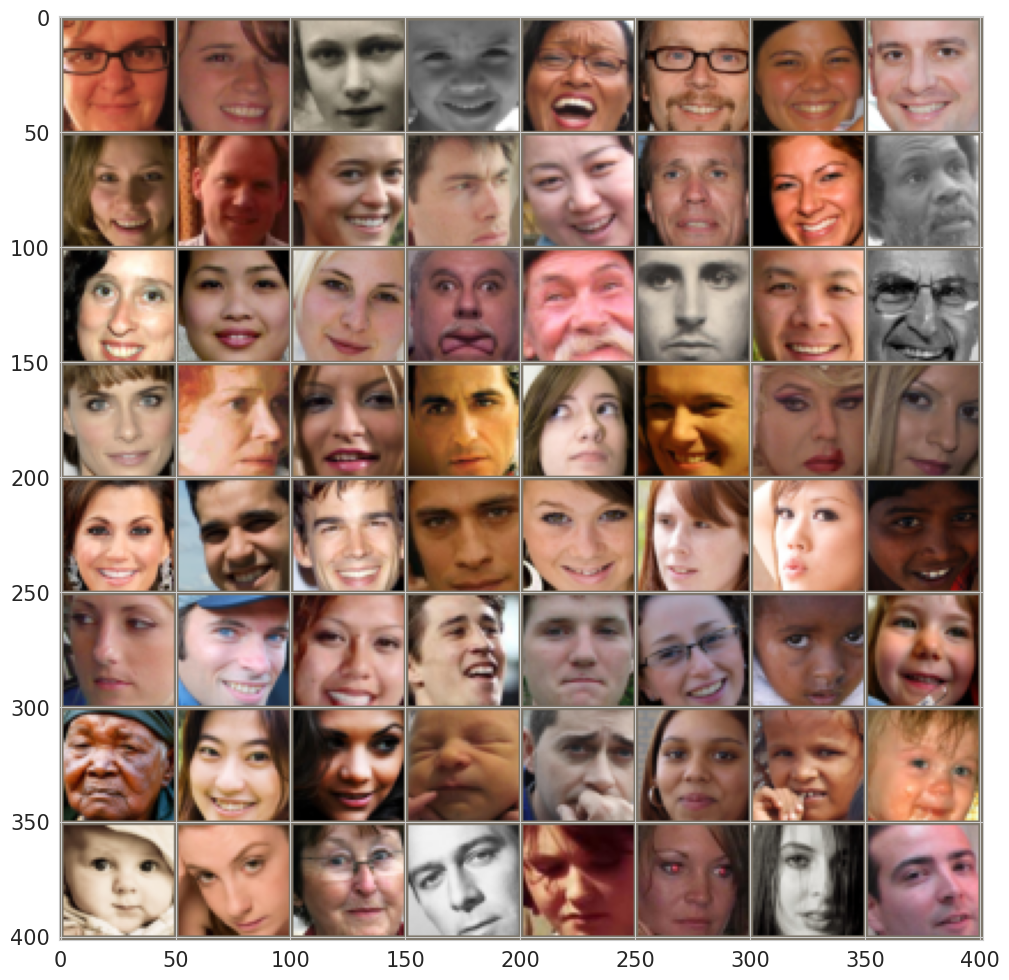

In [202]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
images, real_landmarks, resized_landmarks, rect = next(iter(train_loader))
# cv2.rectangle(image, (rect[0],rect[1]), (rect[2],rect[3]), (255, 0, 0), 2)
# for i in real_landmarks:
#     image = cv2.circle(image, i, radius=0, color=(0, 0, 255), thickness=-1)
# Расположим картинки рядом
out = torchvision.utils.make_grid(image)

imshow(out)

Обучение модели( Пока что возьмем O-Net)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

def plot_losses(train_losses, val_losses, train_RMSE, val_RMSE, thres=0.08, step=0.0001, common_val_auc_0_08=None, image_data = None):
    clear_output()

    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    fig. tight_layout ()
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].set_title('Loss')


    num_data_train = len(train_RMSE)
    num_data_val = len(val_RMSE)

    coord_x_train = np.arange(0, thres + step, step)
    coord_y_train = np.array([np.count_nonzero(train_RMSE <= x) for x in coord_x_train]) / float(num_data_train)

    coord_x_val = np.arange(0, thres + step, step)
    coord_y_val = np.array([np.count_nonzero(val_RMSE <= x) for x in coord_x_val]) / float(num_data_val)

    axs[1].plot(coord_x_train,coord_y_train, label='train')
    axs[1].plot(coord_x_val,coord_y_val, label='val')
    axs[1].set_xlabel('Normilized Poin-to-Point error')
    axs[1].set_ylabel('Proportion of Image')
    axs[1].set_title(f'CDE_AUC_{image_data}={common_val_auc_0_08}')

    for ax in axs:
        ax.legend()

    plt.show()

In [16]:
def train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, image_data):
    train_losses = []
    val_losses = []
    common_train_auc_0_08 = []
    common_val_auc_0_08 = []
    common_train_RMSE = []
    common_val_RMSE = []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_auc_0_08, train_RMSE = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        if val_loader:
          val_loss, val_auc_0_08, val_RMSE = validation_epoch(
              model, criterion, val_loader,
              tqdm_desc=f'Validating {epoch}/{num_epochs}'
          )
        else:
          val_loss = 0
          val_auc_0_08 = 0
          val_RMSE = 0

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        val_losses += [val_loss]
        common_train_auc_0_08 += [train_auc_0_08]
        common_val_auc_0_08 += [val_auc_0_08]
        common_train_RMSE += [train_RMSE]
        common_val_RMSE += [val_RMSE]

        plot_losses(train_losses, val_losses, common_train_RMSE[-1], common_val_RMSE[-1], thres=0.08, step=0.0001, common_val_auc_0_08 = common_val_auc_0_08[-1], image_data = image_data)

        lr = scheduler.optimizer.param_groups[0]['lr']

        print(f'''epoch {epoch},\n
                train_losses: {train_loss:.4f},\n
                val_losses: {val_loss:.4f},\n 
                common_train_auc_0_08: {train_auc_0_08:.4f},\n 
                common_val_auc_0_08: {val_auc_0_08:.4f},\n
                lr: {lr}''')

    return train_losses, val_losses, common_train_auc_0_08, common_val_auc_0_08, common_train_RMSE, common_val_RMSE


def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss = 0.0
    RMSE = []

    model.train()
    for images, real_landmarks, resized_landmarks, rect in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        resized_landmarks = resized_landmarks.to(device)  # resized_landmarks: batch_size x 68X2

        optimizer.zero_grad()
        pred_landmarks = model(images)  # pred_landmarks: batch_size x 68X2
        pred_landmarks = pred_landmarks.reshape(-1,68,2).double()

        loss = criterion(pred_landmarks, resized_landmarks)

        images = images.cpu()
        real_landmarks = real_landmarks.cpu()
        pred_landmarks = pred_landmarks.cpu().detach()
        rect = rect.cpu()

        #upscale pred_landmarks
        upsamle_pred_landmarks = upsample_landmarks(images, pred_landmarks, rect)

        loss.backward()
        optimizer.step()

        # calculate loss 
        train_loss += loss.item() * images.shape[0]

        # calculate metric 
        avg_norm_dist = count_avg_norm_dist_butch(real_landmarks.numpy(), upsamle_pred_landmarks, rect.numpy())
        RMSE = np.concatenate((RMSE, avg_norm_dist))

    train_loss /= len(train_loader.dataset)

    train_auc_0_08 = ced_auc(RMSE, thres=0.08)

    train_RMSE = RMSE

    return train_loss, train_auc_0_08, train_RMSE

@torch.no_grad()
def validation_epoch(model, criterion, val_loader, tqdm_desc):
    val_loss  = 0.0
    RMSE = []

    model.eval()
    for images, real_landmarks, resized_landmarks, rect in tqdm(val_loader, desc=tqdm_desc):
        images = images.to(device)  
        resized_landmarks = resized_landmarks.to(device)

        pred_landmarks = model(images) 
        pred_landmarks = pred_landmarks.reshape(-1,68,2)

        loss = criterion(pred_landmarks, resized_landmarks)

        images = images.cpu()
        real_landmarks = real_landmarks.cpu()
        pred_landmarks = pred_landmarks.cpu().detach()
        rect = rect.cpu()

        #upscale pred_landmarks
        upsamle_pred_landmarks = upsample_landmarks(images, pred_landmarks, rect)

        val_loss += loss.item() * images.shape[0]

        # calculate metric 
        avg_norm_dist = count_avg_norm_dist_butch(real_landmarks.numpy(), upsamle_pred_landmarks, rect.numpy())
        RMSE = np.concatenate((RMSE, avg_norm_dist))

    val_loss /= len(val_loader.dataset)

    # auc_0_08 = ced_auc(RMSE, thres=0.08, draw = True)
    val_auc_0_08 = ced_auc(RMSE, thres=0.08)

    val_RMSE = RMSE

    return val_loss, val_auc_0_08, val_RMSE

In [11]:
from itertools import starmap

def upsample_landmarks(image, landmarks, rect):
    image = image.permute(0,2,3,1).numpy() # BxCxHxW -- BxHxWxC
    landmarks = landmarks.numpy() #[batch_size, 68, 2]
    rect = rect.numpy() ##[batch_size, 4]

    #unresize
    unresize_landmarks = list(starmap(unresize, zip(image, landmarks, rect))) # batch_size x [68, 2]

    # print(unresize_landmarks[0].shape)

    uncropped_landmarks = list(starmap(uncrop, zip(unresize_landmarks, rect)))
    # print( uncropped_landmarks[0].shape, len(uncropped_landmarks), uncropped_landmarks)

    landmarks = np.array(uncropped_landmarks)
    
    return landmarks


def unresize(image, landmarks, rect):

    rect_size = (rect[3]-rect[1],rect[2]-rect[0]) #HXW

    scale_x = image.shape[1] / rect_size[1]
    scale_y = image.shape[0] / rect_size[0]


    unresized_landmarks = np.zeros((68,2))

    unresized_landmarks[:,0] = landmarks[:,0] / scale_x
    unresized_landmarks[:,1] = landmarks[:,1] / scale_y

    return  unresized_landmarks

def uncrop(cropped_landmarks, rect):

    uncropped_landmarks = np.zeros((68,2))
    uncropped_landmarks[:,0] = cropped_landmarks[:,0] + np.full(len(uncropped_landmarks), rect[0]) 
    uncropped_landmarks[:,1] = cropped_landmarks[:,1] + np.full(len(uncropped_landmarks), rect[1]) 

    return uncropped_landmarks

In [12]:
def count_avg_norm_dist_butch(real_landmarks, upsamle_pred_landmarks, rect):

    avg_norm_dist_butch = np.array(list(starmap(count_avg_norm_dist, zip(upsamle_pred_landmarks, real_landmarks, rect)))) # array

    return avg_norm_dist_butch

def count_avg_norm_dist(upsamle_pred_landmarks, real_landmarks, rect):
    W = abs(rect[2] - rect[0])
    H = abs(rect[3] - rect[1])

    normalization_factor = np.sqrt(H * W)
    n_points = real_landmarks.shape[0]

    dist = np.sqrt((np.square(real_landmarks-upsamle_pred_landmarks)).sum(axis=1))

    avg_norm_dist = np.sum(dist) / (n_points * normalization_factor)

    return avg_norm_dist

In [13]:
def ced_auc(RMSE, thres=0.08, step=0.0001):

    num_data = len(RMSE)
    # print(RMSE)
    coord_x = np.arange(0, thres + step, step)
    coord_y = np.array([np.count_nonzero(RMSE <= x) for x in coord_x]) / float(num_data)

    
#  https://stackoverflow.com/questions/13320262/calculating-the-area-under-a-curve-given-a-set-of-coordinates-without-knowing-t
    ced_auc = simpson(coord_y,x = coord_x) / thres

    return ced_auc

In [14]:
class ONet(nn.Module):
    def __init__(self):
        super(ONet, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(3, 32, kernel_size=3) ,
            nn.MaxPool2d(2,2), nn.ReLU()) 
        
        self.layer2 = nn.Sequential( nn.Conv2d(32, 64, kernel_size=3) ,
            nn.MaxPool2d(2,2), nn.ReLU())  
        
        self.layer3 = nn.Sequential( nn.Conv2d(64, 64, kernel_size=3) ,
            nn.MaxPool2d(2,2), nn.ReLU()) 
        
        self.layer4 = nn.Sequential( nn.Conv2d(64, 128, kernel_size=2) ,
            nn.ReLU())
        
        self.fc1 = nn.Linear(1152, 256) 
        self.fc2 = nn.Linear(256, 136) #68Х2
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = torch.flatten(out, 1) 
        out = self.fc1(out)
        out = F.relu(out) 
        out = self.fc2(out) 
        return out

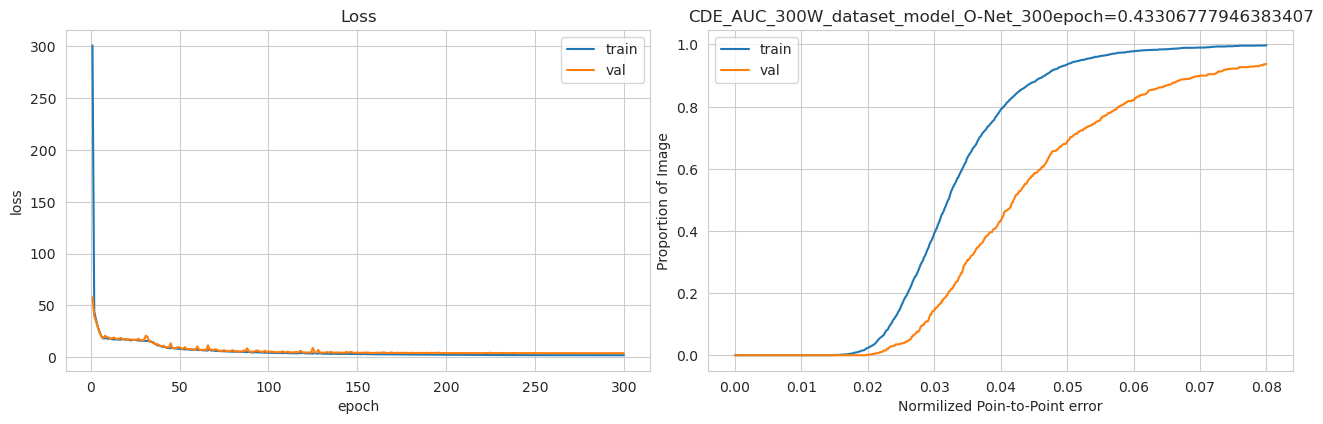

epoch 300,

                train_losses: 1.9932,

                val_losses: 3.9881,
 
                common_train_auc_0_08: 0.5764,
 
                common_val_auc_0_08: 0.4331,

                lr: 0.0


In [36]:
model = ONet()
model = model.to(device)

num_epochs = 300


# В качестве cost function используем кросс-энтропию
criterion = torch.nn.MSELoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.001,
    # weight_decay=2e-05
)

# scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

NAME = '300W_dataset_model_O-Net_300epoch'
image_data = NAME

train_losses, val_losses, common_train_auc_0_08, common_val_auc_0_08, common_train_RMSE, common_val_RMSE = train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, image_data
)


#создаем словать из того что хотим сохранить
# NAME = '300W_dataset_model_O-Net'
state = {
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': train_losses[-1],
    'common_train_auc_0_08': common_train_auc_0_08[-1],
    'common_val_auc_0_08': common_val_auc_0_08[-1],
    'common_train_RMSE': common_train_RMSE[-1],
    'common_val_RMSE': common_val_RMSE[-1],
}
torch.save(state, f'./model/checkpoints_{NAME}.pth')


Получим результаты для тестовой части

In [18]:
@torch.no_grad()
def model_inference(model, val_loader, tqdm_desc=''):
    model.eval()
    RMSE = []
    pred_landmarks_model = None

    for images, real_landmarks, resized_landmarks, rect in tqdm(val_loader, desc=tqdm_desc):
        images = images.to(device)  
        resized_landmarks = resized_landmarks.to(device)

        pred_landmarks = model(images) 
        pred_landmarks = pred_landmarks.reshape(-1,68,2)

        images = images.cpu()
        real_landmarks = real_landmarks.cpu()
        pred_landmarks = pred_landmarks.cpu().detach()
        rect = rect.cpu()
        
        #upscale pred_landmarks
        upsamle_pred_landmarks = upsample_landmarks(images, pred_landmarks, rect)

        # calculate metric 
        avg_norm_dist = count_avg_norm_dist_butch(real_landmarks.numpy(), upsamle_pred_landmarks, rect.numpy())


        RMSE = np.concatenate((RMSE, avg_norm_dist))

        if pred_landmarks_model is not None:
            pred_landmarks_model = np.concatenate((pred_landmarks_model, upsamle_pred_landmarks))
        else:
            pred_landmarks_model = upsamle_pred_landmarks

    test_auc_0_08 = ced_auc(RMSE, thres=0.08)

    return RMSE, test_auc_0_08, pred_landmarks_model

In [19]:
import pickle

RMSE, test_auc_0_08, pred_landmarks_model = model_inference(model, test_loader, tqdm_desc='model_inference')

print(pred_landmarks_model.shape, len(RMSE))

# save result
SAVE_PATH = './results/predictions_300W_ONet_300epoch.pkl'

result_model_inference= {'RMSE': RMSE, 'test_auc_0_08': test_auc_0_08, 'pred_landmarks_model': pred_landmarks_model}

if os.path.exists(SAVE_PATH):
      os.remove(SAVE_PATH)
with open(SAVE_PATH, 'wb') as fp:
        pickle.dump(result_model_inference, fp)



model_inference:   0%|          | 0/11 [00:00<?, ?it/s]

(657, 68, 2) 657


Построим график CED для test_300W

In [20]:
def plot_ced_auc_test(RMSE, test_auc_0_08, image_data, thres=0.08, step=0.0001):

    num_data = len(RMSE)

    coord_x = np.arange(0, thres + step, step)
    coord_y = np.array([np.count_nonzero(RMSE <= x) for x in coord_x]) / float(num_data)

    plt.plot(coord_x,coord_y)
    plt.xlabel("Normilized Poin-to-Point error")
    plt.ylabel("Proportion of Image")
    plt.title(f"CED: AUC = {float('{:.4f}'.format(test_auc_0_08))},data = {image_data}")
    plt.grid(visible = True)

    return test_auc_0_08

0.449090113735783

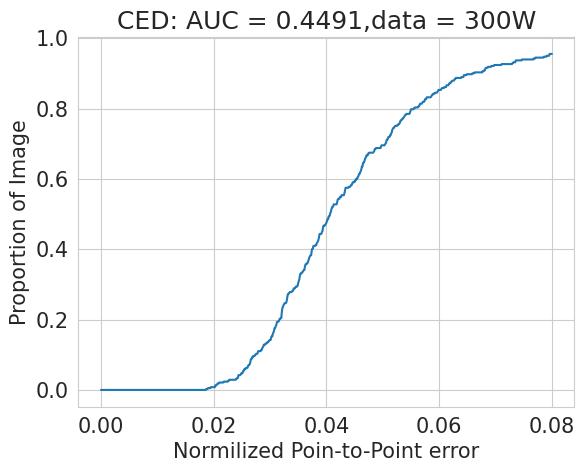

In [22]:
with open('./results/predictions_300W_ONet.pkl', 'rb') as fp:
     data_result = pickle.load(fp)
RMSE_300W_test_ONet = data_result['RMSE']
auc_0_08_300W_test_ONet = data_result['test_auc_0_08']
plot_ced_auc_test(RMSE_300W_test_ONet, auc_0_08_300W_test_ONet, image_data = '300W')

Dataset = Menpo

In [23]:
RMSE, test_auc_0_08, pred_landmarks_model = model_inference(model, test_loader, tqdm_desc='model_inference')

# save result
SAVE_PATH = './results/predictions_Menpo_ONet_300epoch.pkl'

result_model_inference= {'RMSE': RMSE, 'test_auc_0_08': test_auc_0_08, 'pred_landmarks_model': pred_landmarks_model}

if os.path.exists(SAVE_PATH):
      os.remove(SAVE_PATH)
with open(SAVE_PATH, 'wb') as fp:
        pickle.dump(result_model_inference, fp)

model_inference:   0%|          | 0/11 [00:00<?, ?it/s]

Результаты DLIB model На тесте.

In [30]:
def test_dlib(datasets_path):

    predictor = dlib.shape_predictor('./model_weights/shape_predictor_68_face_landmarks.dat')
    test_dataset_dlib = ImagesDataset( df = pd.read_pickle(datasets_path),
                                      image_size = None,
                                      transform=None)             

    RMSE_dlib = []
    for index in tqdm(range(len(test_dataset_dlib))):
        images, real_landmarks, _ , rect = test_dataset_dlib[index]

        dlib_rect = dlib.rectangle(left=rect[0], top=rect[1], right=rect[2], bottom=rect[3]) 
        pred_landmarks = predictor(np.array(images), dlib_rect)

        pred_landmarks = shape_to_np(pred_landmarks)

        avg_norm_dist = count_avg_norm_dist(pred_landmarks, real_landmarks, rect)
        RMSE_dlib.append(avg_norm_dist)

    RMSE_dlib = np.sort(RMSE_dlib)

    ced_auc_0_08_dlib = ced_auc(RMSE_dlib,thres=0.08, step=0.0001)

    print(f'''RMSE_dlib {RMSE_dlib},\n
        ced_auc_0_08_dlib: {ced_auc_0_08_dlib:.4f}''')

    return ced_auc_0_08_dlib, RMSE_dlib, pred_landmarks 

In [31]:
def shape_to_np(shape):
    coords = np.zeros((68, 2))
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

Модель DLIB датасет 300W

In [481]:
ced_auc_0_08_300W_dlib, RMSE_300W_test_dlib, pred_landmarks_300W_dlib  = test_dlib(datasets_path = '/home/ann/projects/vision_lab/df_300W_test.pickle')

  0%|          | 0/381 [00:00<?, ?it/s]

RMSE_dlib [0.00837958 0.00851265 0.00886944 0.00896913 0.00903617 0.00931633
 0.00965237 0.00995156 0.01003885 0.01004661 0.01020399 0.0102416
 0.01028575 0.01044593 0.01049587 0.01055307 0.01067824 0.01068171
 0.01085012 0.01086932 0.01092639 0.01097564 0.01102284 0.01103155
 0.01106672 0.01110143 0.01112768 0.01123834 0.01136311 0.01145292
 0.01146578 0.01148    0.01151125 0.01151553 0.01160036 0.01160767
 0.0116537  0.01179631 0.01186328 0.0120172  0.01210013 0.01212389
 0.01218306 0.01218575 0.01224925 0.01228095 0.01230177 0.01232833
 0.01241753 0.01245835 0.01248617 0.01251092 0.01265804 0.01275277
 0.01275894 0.01276028 0.01278728 0.01286171 0.01289376 0.0129109
 0.01295495 0.012986   0.0130115  0.01301187 0.0130708  0.01317245
 0.01318898 0.01327509 0.01328059 0.0133872  0.01341361 0.01346236
 0.01350849 0.01355392 0.01360716 0.01382468 0.01386031 0.01397613
 0.01411492 0.01412243 0.01414922 0.01421286 0.01422478 0.01429232
 0.01434832 0.01437643 0.01440577 0.01440685 0.0144211

Сохраним данные модели DLIB для датасета 300W

In [478]:
# save result
SAVE_PATH = './results/predictions_300W_DLIB.pkl'

result_model_300W_DLIB_inference= {'RMSE': RMSE_300W_test_dlib, 'test_auc_0_08': ced_auc_0_08_300W_dlib, 'pred_landmarks_model': pred_landmarks_300W_dlib}

if os.path.exists(SAVE_PATH):
      os.remove(SAVE_PATH)
with open(SAVE_PATH, 'wb') as fp:
        pickle.dump(result_model_300W_DLIB_inference, fp)

Построим график для датасета 300W для моделей DLIB и O-Net. ( По заданию - знаю что DLIB обучулась н аданном датасете, но чтобы сравнить визуально разницу - посчитала лучше - построить)

In [26]:
plt.rcParams.update({'font.size': 10})


def plot_CED_AUC_compare(RMSE_model, auc_model, RMSE_dlib, auc_dlib, thres=0.08, step=0.0001, type_model = 'ONet', image_data = '300W' ):

    clear_output()
    fig, ax = plt.subplots()

    num_data_my_model = len(RMSE_model)
    num_data_dlib = len(RMSE_dlib)

    coord_x_my_model = np.arange(0, thres + step, step)
    coord_y_my_model = np.array([np.count_nonzero(RMSE_model <= x) for x in coord_x_my_model]) / float(num_data_my_model)

    coord_x_dlib = np.arange(0, thres + step, step)
    coord_y_dlib = np.array([np.count_nonzero(RMSE_dlib <= x) for x in coord_x_dlib]) / float(num_data_dlib)

    ax.plot(coord_x_my_model,coord_y_my_model, label= f'{type_model}:{auc_model:.4f}')
    ax.plot(coord_x_dlib,coord_y_dlib, label=f'DLIB:{auc_dlib:.4f}')
    ax.set_xlabel('Normilized Poin-to-Point error')
    ax.set_ylabel('Proportion of Image')
    ax.set_title(f'CDE_AUC_{image_data}')

    ax.legend()

    plt.show()

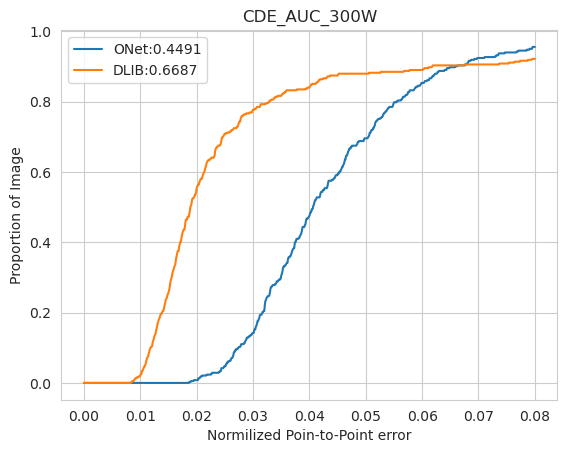

In [503]:
plot_CED_AUC_compare(RMSE_model = RMSE_300W_test_ONet ,
                    auc_model =  auc_0_08_300W_test_ONet,
                    RMSE_dlib = RMSE_300W_test_dlib, 
                    auc_dlib = ced_auc_0_08_300W_dlib,
                    thres=0.08,
                    step=0.0001,
                    type_model = 'ONet',
                    image_data = '300W')

Модель DLIB для датасета Menpo

In [32]:
ced_auc_0_08_Menpo_dlib, RMSE_Menpo_test_dlib, pred_landmarks_Menpo_dlib  = test_dlib(datasets_path = '/home/ann/projects/vision_lab/df_Menpo_test.pickle')

  0%|          | 0/657 [00:00<?, ?it/s]

RMSE_dlib [0.01041269 0.01120455 0.01227409 0.01315996 0.01317899 0.01322656
 0.01324625 0.01328855 0.01348651 0.01349364 0.01352207 0.01366827
 0.01371477 0.0138464  0.01388083 0.01412381 0.01414654 0.01433276
 0.01434325 0.01440255 0.01449972 0.01451932 0.01471518 0.01477614
 0.0147891  0.01513073 0.01515197 0.01517361 0.01530382 0.01531369
 0.01535031 0.01542506 0.01554852 0.01569728 0.01575775 0.01590606
 0.01596614 0.01609544 0.01609764 0.01610728 0.01619981 0.0162133
 0.01624533 0.01624603 0.01632705 0.01645722 0.01666886 0.01673851
 0.01688461 0.01690399 0.01696828 0.01697466 0.01701246 0.0170438
 0.01711609 0.01739755 0.01740784 0.01755086 0.01760852 0.01763073
 0.01764144 0.01766274 0.01771252 0.01778351 0.01790276 0.0179069
 0.01791729 0.01809459 0.01823803 0.01833418 0.01843988 0.01847277
 0.01849665 0.01850253 0.01852106 0.01859499 0.01864729 0.01865534
 0.01875342 0.01886029 0.01887048 0.01887842 0.0189443  0.01909863
 0.01912807 0.01915605 0.01924664 0.01925648 0.01927486

In [29]:
# save result
SAVE_PATH = './results/predictions_Menpo_DLIB.pkl'

result_model_300W_DLIB_inference= {'RMSE': RMSE_300W_test_dlib, 'test_auc_0_08': ced_auc_0_08_300W_dlib, 'pred_landmarks_model': pred_landmarks_300W_dlib}

if os.path.exists(SAVE_PATH):
      os.remove(SAVE_PATH)
with open(SAVE_PATH, 'wb') as fp:
        pickle.dump(result_model_300W_DLIB_inference, fp)

657

Построим график для датасета Menpo для моделей DLIB и ONet.

In [33]:
with open('./results/predictions_Menpo_DLIB.pkl', 'rb') as fp:
     data_result = pickle.load(fp)
RMSE_Menpo_test_dlib = data_result['RMSE']
ced_auc_0_08_300W_dlib = data_result['test_auc_0_08']

In [24]:
with open('./results/predictions_Menpo_ONet_300epoch.pkl', 'rb') as fp:
     data_result = pickle.load(fp)
RMSE_Menpo_test_ONet = data_result['RMSE']
auc_0_08_Menpo_test_ONet = data_result['test_auc_0_08']

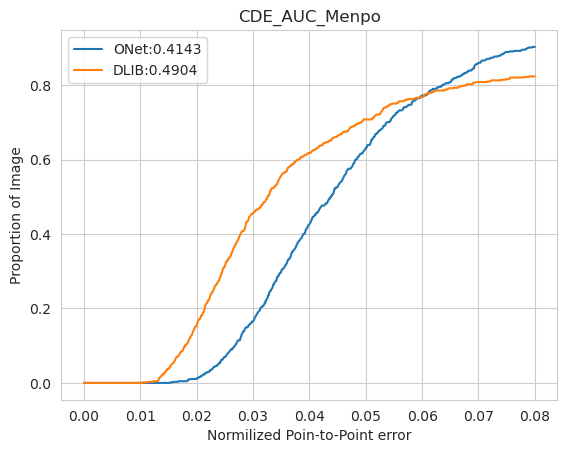

In [34]:
plot_CED_AUC_compare(RMSE_model = RMSE_Menpo_test_ONet ,
                    auc_model =  auc_0_08_Menpo_test_ONet,
                    RMSE_dlib = RMSE_Menpo_test_dlib, 
                    auc_dlib = ced_auc_0_08_Menpo_dlib,
                    thres=0.08,
                    step=0.0001,
                    type_model = 'ONet',
                    image_data = 'Menpo')